# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [ ]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=66329d02c761f41c0f57cdf1fa2b2d46621c31a958794e043e7f2ff6725b58bd
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=049e5bd3fcc5dbf824f078a6c5aab6c109a5844cf89c62bdc540bf91a583bcd4
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [ ]:
# add any additional libaries you need here
import nltk
nltk.download('brown')


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [ ]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [ ]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [ ]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [ ]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [ ]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


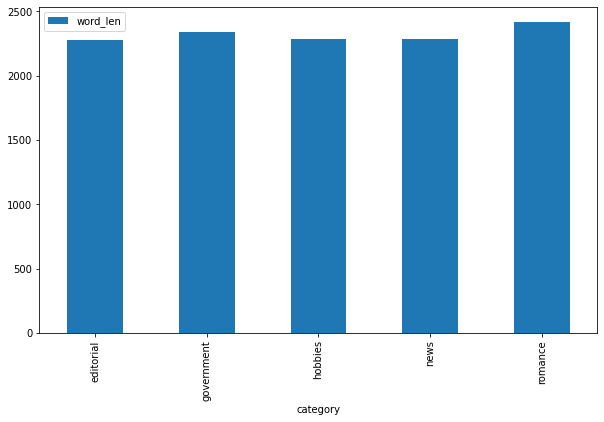

In [ ]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [ ]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [ ]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: they hold the number of words occured in each topic 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [ ]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [ ]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [58]:
# Your code here
#seeing if there any outliers 
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0


array([18.17705433, 25.86545606, 29.54609649, 14.40020472, 12.0111884 ])

In [75]:
#saving the matrix of the new topic 
df["nmf_topic"] = np.argmax(W_text_matrix, axis = 1).astype(str)

In [76]:
#for loop that count the unique topic 
for label in df['nmf_topic'].unique():
    print(f"topic {label} observes original label counts of:")
    print(df[df['nmf_topic'] == label]['category'].value_counts())
    print()

topic 2 observes original label counts of:
government    26
hobbies       26
news          11
editorial      2
Name: category, dtype: int64

topic 0 observes original label counts of:
editorial     20
news           8
government     4
Name: category, dtype: int64

topic 1 observes original label counts of:
romance      29
hobbies       8
editorial     4
Name: category, dtype: int64

topic 4 observes original label counts of:
news         8
editorial    1
hobbies      1
Name: category, dtype: int64

topic 3 observes original label counts of:
news       17
hobbies     1
Name: category, dtype: int64



Q: How does your five-topic NMF model compare to the original Brown categories? 

A: <!-- Your answer here --> it seem that they inly agree on the news and hobbies but the other's they disagree 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [63]:
# Your code here
#creating the SVD model
from sklearn.decomposition import TruncatedSVD
svd_text_model = TruncatedSVD(n_components = 10, random_state=42)

In [64]:
#creating the matrix 
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [65]:
#saving the matrix of the new topic 
df["svd_topic"] = np.argmax(W_svd_text_matrix, axis = 1).astype(str)

In [66]:
#for loop that count the unique topic 
for label in df['svd_topic'].unique():
    print(f"topic {label} observes original label counts of:")
    print(df[df['svd_topic'] == label]['category'].value_counts())
    print()

topic 0 observes original label counts of:
news          33
hobbies       33
editorial     27
romance       21
government    15
Name: category, dtype: int64

topic 8 observes original label counts of:
government    6
Name: category, dtype: int64

topic 9 observes original label counts of:
government    5
Name: category, dtype: int64

topic 7 observes original label counts of:
government    2
hobbies       1
Name: category, dtype: int64

topic 6 observes original label counts of:
government    2
news          1
hobbies       1
Name: category, dtype: int64

topic 4 observes original label counts of:
news    7
Name: category, dtype: int64

topic 3 observes original label counts of:
news    3
Name: category, dtype: int64

topic 1 observes original label counts of:
romance    8
Name: category, dtype: int64

topic 5 observes original label counts of:
hobbies    1
Name: category, dtype: int64



Q: How does your five-topic LSA model compare to the original Brown categories? 

A: <!-- Your answer here --> they a gree on the goverment for the most part but for the rest it seem that they give no importance 

In [74]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.06)
  kennedy (0.82)
  laos (0.78)

Topic 03
  mrs (29.99)
  club (6.67)
  game (6.21)
  jr (5.71)
  dallas (5.47)

Topic 04
  game (4.46)
  league (3.20)
  baseball (3.18)
  ball (3.02)
  team (2.91)

Topic 05
  mrs (4.51)
  music (1.15)
  af (1.09)
  khrushchev (1.04)
  miss (0.98)

Topic 06
  faculty (184.24)
  college (178.80)
  student (139.55)
  shall (123.17)
  university (114.98)

Topic 07
  mrs (10.11)
  sales (5.92)
  marketing (4.33)
  billion (4.33)
  business (4.01)

Topic 08
  state (26.37)
  states (18.26)
  united (16.73)
  shall (15.81)
  mrs (15.67)

Topic 09
  shall (19.61)
  united (17.02)
  board (14.47)
  states (11.02)
  court (10.58)


Q: What is your interpretation of the display topics output? 

A: there a lot more topic SVD model, spliting each paragraph more into there own topic, making more words 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [67]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)

In [68]:
#creating the matrix 
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [69]:
#saving the matrix of the new topic 
df["lda_topic"] = np.argmax(W_lda_text_matrix, axis = 1).astype(str)

In [70]:
#for loop that count the unique topic 
for label in df['lda_topic'].unique():
    print(f"topic {label} observes original label counts of:")
    print(df[df['lda_topic'] == label]['category'].value_counts())
    print()

topic 8 observes original label counts of:
editorial     15
news          12
government    11
romance        1
hobbies        1
Name: category, dtype: int64

topic 5 observes original label counts of:
romance       20
news          11
hobbies        8
editorial      5
government     1
Name: category, dtype: int64

topic 1 observes original label counts of:
government    3
hobbies       3
editorial     2
news          1
Name: category, dtype: int64

topic 2 observes original label counts of:
editorial     5
government    3
news          3
hobbies       2
Name: category, dtype: int64

topic 9 observes original label counts of:
government    4
hobbies       4
Name: category, dtype: int64

topic 7 observes original label counts of:
government    5
hobbies       5
news          1
Name: category, dtype: int64

topic 4 observes original label counts of:
romance       6
government    2
Name: category, dtype: int64

topic 6 observes original label counts of:
news          9
government    1
hobb

In [71]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  clay (0.54)
  game (0.47)
  place (0.45)
  cut (0.45)
  home (0.44)

Topic 01
  pool (0.77)
  use (0.71)
  national (0.70)
  area (0.57)
  good (0.56)

Topic 02
  million (0.60)
  military (0.57)
  sales (0.54)
  aircraft (0.54)
  equipment (0.50)

Topic 03
  feed (3.04)
  said (1.47)
  head (1.08)
  meeting (0.94)
  daily (0.91)

Topic 04
  said (1.83)
  sam (0.67)
  eyes (0.63)
  thought (0.63)
  little (0.58)

Topic 05
  mrs (1.05)
  said (0.88)
  old (0.67)
  mr (0.56)
  man (0.56)

Topic 06
  said (2.73)
  board (0.85)
  000 (0.66)
  court (0.56)
  county (0.55)

Topic 07
  state (1.08)
  medical (0.75)
  shelter (0.68)
  program (0.53)
  service (0.53)

Topic 08
  state (0.85)
  united (0.78)
  states (0.72)
  government (0.70)
  president (0.67)

Topic 09
  fiscal (1.00)
  property (0.86)
  island (0.69)
  tax (0.69)
  state (0.61)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: <!-- Your answer here -->  that it split the paragraph  more making different topics that are to related to each other. there is some key words that repeat 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: <!-- Your answer here --> it got the news, goverment correct but missing editorial for majority of them 

In [72]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [73]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: from the topic 9 has a lot in commen with topic 3, 2, 8, 10 and topic 6 and 5 have some agreements 
